# PCA, Autoencoders

### import, load etc

In [1]:
%env CUDA_VISIBLE_DEVICES=1

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import numpy as np

import tensorflow as tf
import keras

env: CUDA_VISIBLE_DEVICES=1


Using TensorFlow backend.


In [2]:
from lfw_dataset import fetch_lfw_dataset

In [3]:
X, attr = fetch_lfw_dataset()

In [4]:
X = X.astype('float32') / 256.0

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.1)

## Faces!

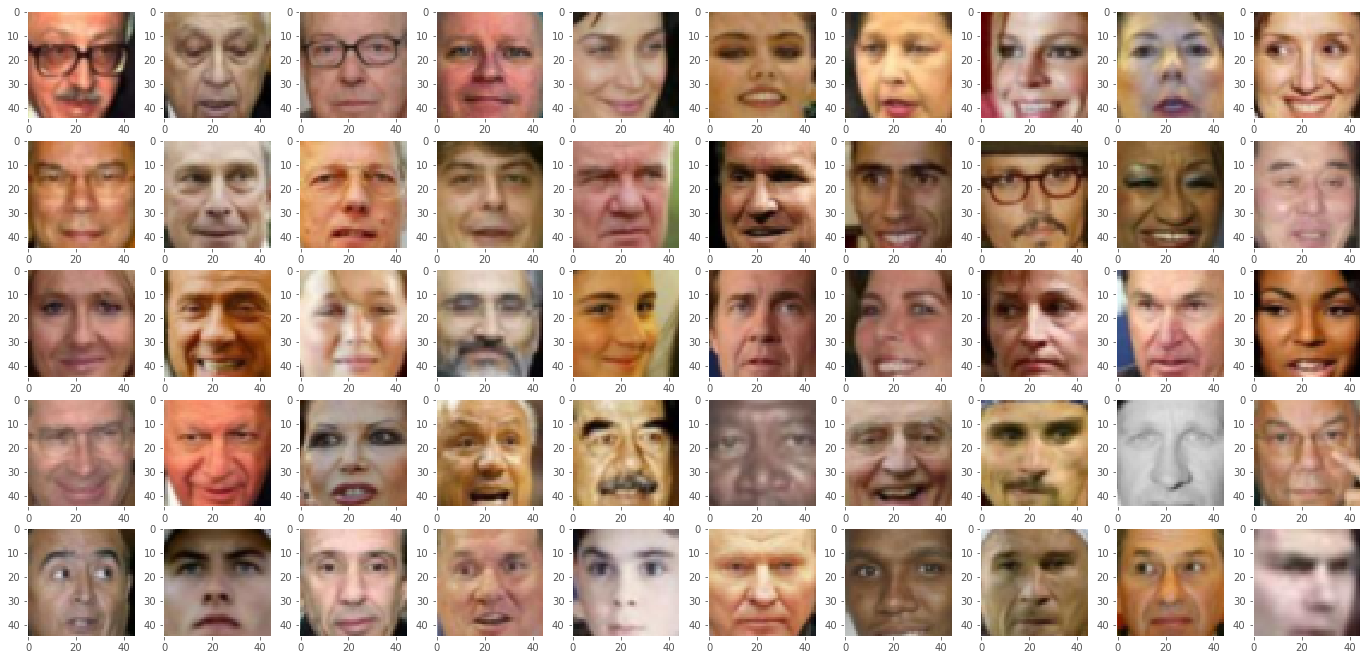

In [6]:
cols = 10
rows = 5
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        k = np.random.randint(0, X_train.shape[0])

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        im = ax.imshow(X_train[k])
plt.show()

### True data scientist collects its own test data!

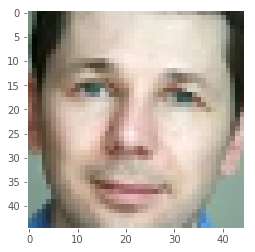

In [123]:
from scipy.misc import imread

X_andrey = imread(name='andrey.jpg') / 255.0

plt.imshow(X_andrey)
plt.grid('off')

## Simple start: PCA

Just a cheat sheet:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

- $n$ - number of objects;
- $m$ - original dimensionality;
- $d$ - target dimensionality;
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;

    $$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$


### PCA = DenseLayer(activation=linear) -> DenseLayer(activation=linear)

PCA can be seen as a special case of an Neural Network.

Consider a dense layer with $d$ units:
    $$\mathrm{dense}(X) = f(X W + b)$$
where:
- $f$ - nonlinearity (sigmoid, $\tanh$ etc);
- $X \in \mathbb{R}^{n \times m}$ - object matrix;
- $W \in \mathrm{m \times d}$, $b \in \mathbb{R}^d$ - layer's parameters;

and PCA:
   $$\|(X W) \hat{W} - X - \mu\|^2_2 \to_{W, \hat{W}} \min$$

where:
  - $W$ - orthogonal.

In [7]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Reshape, Flatten

In [8]:
def make_pca():
    inputs = Input(shape=(45, 45, 3))
    flatten = Reshape((45 * 45 * 3, ))(inputs)
    encoded = Dense(64, activation='linear')(flatten)
    decoded = Dense(45 * 45 * 3, activation='linear')(encoded)
    shaped = Reshape((45, 45, 3))(decoded)
    
    return Model(inputs=inputs, outputs=shaped), Model(inputs=inputs, outputs=encoded)

In [9]:
pca, pca_encoder = make_pca()

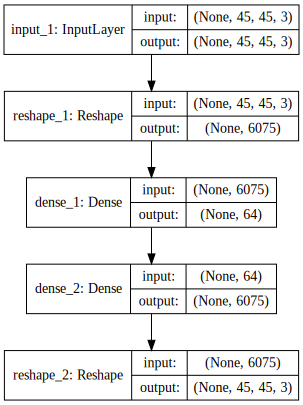

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(pca, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
from keras.optimizers import Adamax
from keras.objectives import MSE

In [12]:
pca.compile(optimizer=Adamax(lr=1.0e-3), loss=[MSE])

In [13]:
pca.fit(X_train, X_train, epochs=16)

Epoch 1/16
11828/11828 [==============================] - 2s - loss: 0.0237     
Epoch 2/16
11828/11828 [==============================] - 2s - loss: 0.0115     
Epoch 3/16
11828/11828 [==============================] - 2s - loss: 0.0092     
Epoch 4/16
11828/11828 [==============================] - 1s - loss: 0.0076     
Epoch 5/16
11828/11828 [==============================] - 1s - loss: 0.0065     
Epoch 6/16
11828/11828 [==============================] - 1s - loss: 0.0056     
Epoch 7/16
11828/11828 [==============================] - 1s - loss: 0.0050     
Epoch 8/16
11828/11828 [==============================] - 1s - loss: 0.0045     
Epoch 9/16
11828/11828 [==============================] - 1s - loss: 0.0041     
Epoch 10/16
11828/11828 [==============================] - 1s - loss: 0.0039     
Epoch 11/16
11828/11828 [==============================] - 1s - loss: 0.0037     
Epoch 12/16
11828/11828 [==============================] - 1s - loss: 0.0036     
Epoch 13/16
11828/11828 [

In [14]:
X_reco = pca.predict(X_test)
code = pca_encoder.predict(X_test)

In [15]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.00324952


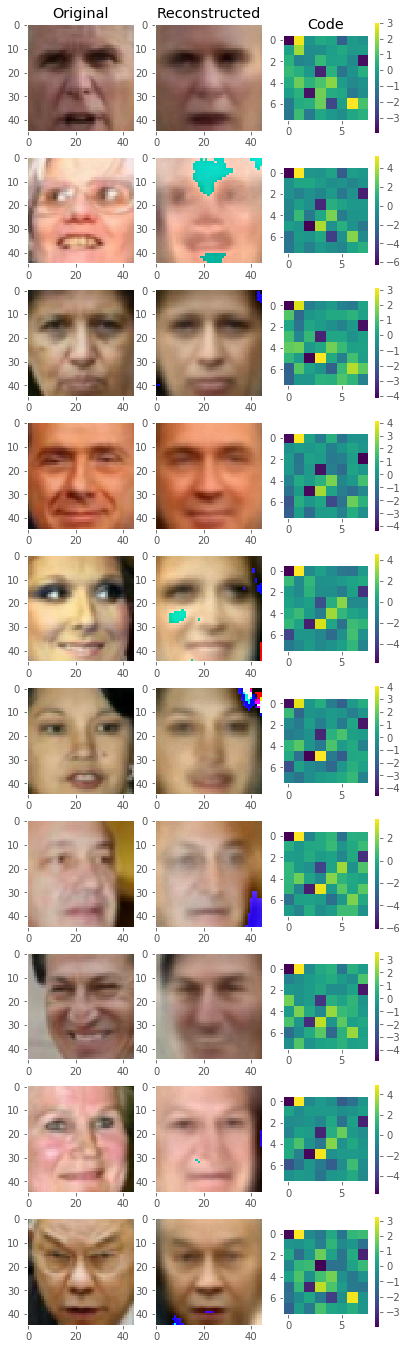

In [16]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(8, 8), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

## Extending to AutoEncoder

Just add more layers!

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

In [17]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Reshape, BatchNormalization
from keras.activations import relu, elu, tanh
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal, glorot_uniform

In [25]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(45, 45, 3))
    flatten = Reshape((45 * 45 * 3, ))(inputs)
    
    dense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(flatten)
    
    net = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(net)
    
    dense3 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense2)

    encoded = Dense(
        64, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense3)
    
    dedense1 = Dense(
        256, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    dedense3 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense2)
    
    decoded = Dense(
        45 * 45 * 3, activation='linear',
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense3)

    shaped = Reshape((45, 45, 3), name='decoded')(decoded)
    
    return Model(inputs=inputs, outputs=shaped), Model(inputs=inputs, outputs=encoded)

In [26]:
ae, ae_encoder = make_autoencoder()

In [27]:
from keras.optimizers import Adadelta
from keras.objectives import MSE

from keras.regularizers import l2, l1

In [28]:
ae.compile(optimizer=Adadelta(), loss=MSE)

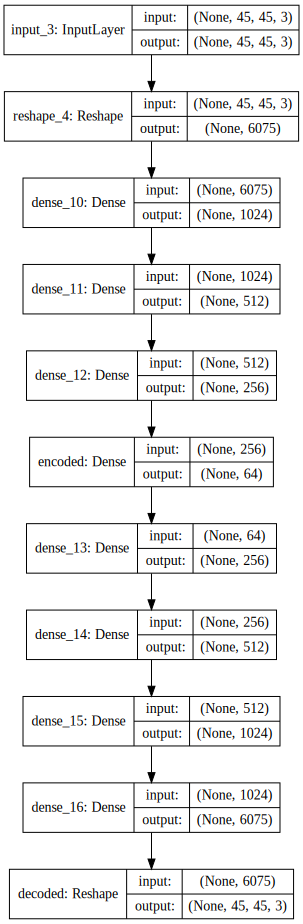

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [30]:
ae.fit(X_train, X_train, epochs=16)

Epoch 1/16
11828/11828 [==============================] - 13s - loss: 0.0561    
Epoch 2/16
11828/11828 [==============================] - 13s - loss: 0.0286    
Epoch 3/16
11828/11828 [==============================] - 13s - loss: 0.0261    
Epoch 4/16
11828/11828 [==============================] - 13s - loss: 0.0241    
Epoch 5/16
11828/11828 [==============================] - 13s - loss: 0.0229    
Epoch 6/16
11828/11828 [==============================] - 13s - loss: 0.0220    
Epoch 7/16
11828/11828 [==============================] - 13s - loss: 0.0212    
Epoch 8/16
11828/11828 [==============================] - 13s - loss: 0.0201    
Epoch 9/16
11828/11828 [==============================] - 13s - loss: 0.0177    
Epoch 10/16
11828/11828 [==============================] - 13s - loss: 0.0173    
Epoch 11/16
11828/11828 [==============================] - 13s - loss: 0.0171    
Epoch 12/16
11828/11828 [==============================] - 13s - loss: 0.0168    
Epoch 13/16
11828/11828 [

In [45]:
X_reco = ae.predict(X_test)
code = ae_encoder.predict(X_test)

In [46]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.0143203


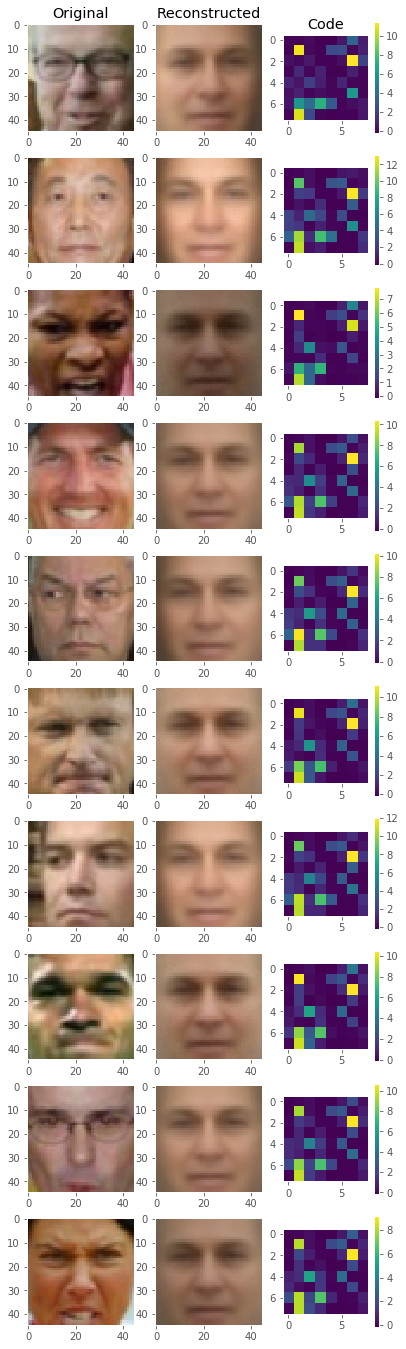

In [47]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(8, 8), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

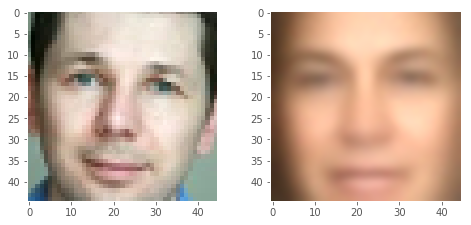

In [124]:
X_andrey_reco = ae.predict(X_andrey.reshape(-1, 45, 45, 3)).reshape(45, 45, 3)

fig = plt.figure(figsize=(8, 3.5))

ax = fig.add_subplot(1, 2, 1)
ax.grid('off')
im = ax.imshow(X_andrey)
if i == 0:
    ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
ax.grid('off')
im = ax.imshow(X_andrey_reco, interpolation='bicubic')
if i == 0:
    ax.set_title('Reconstructed')
    
plt.show()

### Images $\Rightarrow$ convolutions

In [52]:
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal
from keras.activations import relu
from keras.losses import MSE

In [149]:
def make_conv_autoencoder():
    inputs = Input(shape=(45, 45, 3))
    net = inputs
    
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    
    net = Conv2D(filters=32, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    net = Conv2D(filters=64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    
    net = Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    
    net = Reshape((4 * 4 * 128, ))(net)
    net = Dense(64, activation=leaky_relu)(net)
    
    encoded = net
    
    net = Dense(4 * 4 * 128)(net)
    net = Reshape((4, 4, 128))(net)
    
    net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    
    net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 32, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 3, kernel_size=(2, 2), activation='linear', padding='valid')(net)
    
    #net = Cropping2D(cropping=((1, 0), (1, 0)))(net)
    
    return Model(inputs=inputs, outputs=net), Model(inputs=inputs, outputs=encoded)

In [150]:
cae, cae_encoder = make_conv_autoencoder()

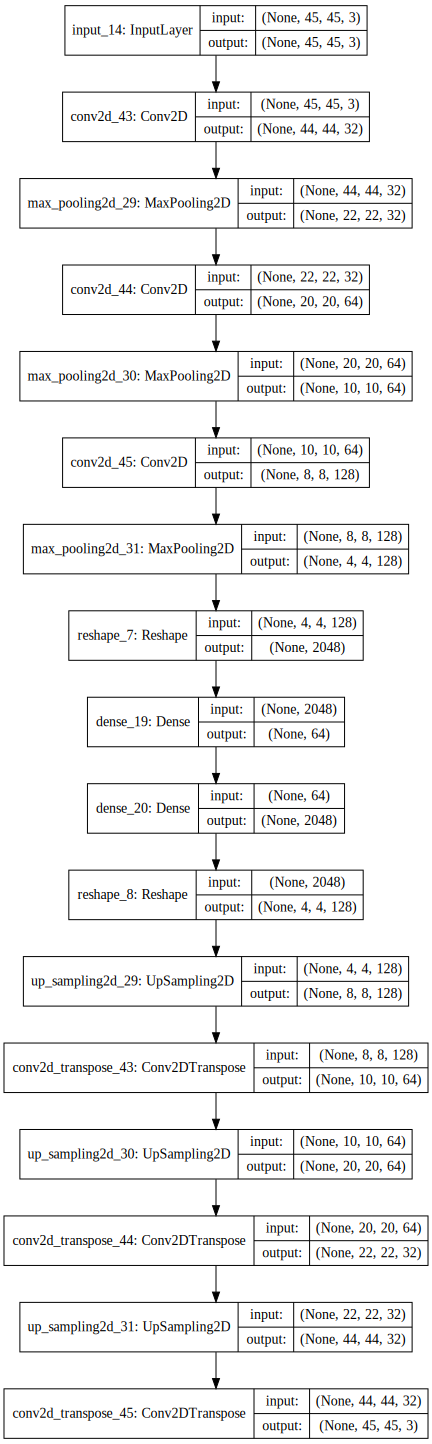

In [151]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cae, show_shapes=True).create(prog='dot', format='svg'))

In [56]:
### Just for fun, let's see how MAE-based AE differs from MSE-based one.
### Plus MAE contains AE...
cae.compile(optimizer='adamax', loss=MSE)

In [57]:
cae.fit(X_train, X_train, epochs=32)

Epoch 1/32
11828/11828 [==============================] - 7s - loss: 0.0251     
Epoch 2/32
11828/11828 [==============================] - 7s - loss: 0.0098     
Epoch 3/32
11828/11828 [==============================] - 7s - loss: 0.0078     
Epoch 4/32
11828/11828 [==============================] - 7s - loss: 0.0068     
Epoch 5/32
11828/11828 [==============================] - 7s - loss: 0.0062     
Epoch 6/32
11828/11828 [==============================] - 7s - loss: 0.0057     
Epoch 7/32
11828/11828 [==============================] - 7s - loss: 0.0054     
Epoch 8/32
11828/11828 [==============================] - 7s - loss: 0.0050     
Epoch 9/32
11828/11828 [==============================] - 7s - loss: 0.0048     
Epoch 10/32
11828/11828 [==============================] - 7s - loss: 0.0046     
Epoch 11/32
11828/11828 [==============================] - 7s - loss: 0.0045     
Epoch 12/32
11828/11828 [==============================] - 7s - loss: 0.0043     
Epoch 13/32
11828/11828 [

In [63]:
X_reco = cae.predict(X_test)
code = cae_encoder.predict(X_test)

In [64]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.00337609


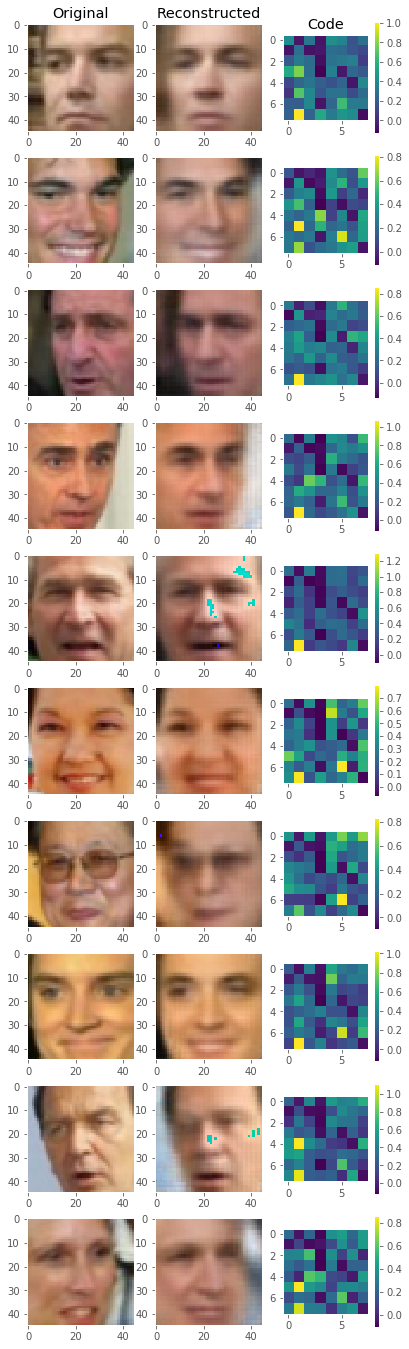

In [70]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(8, 8), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

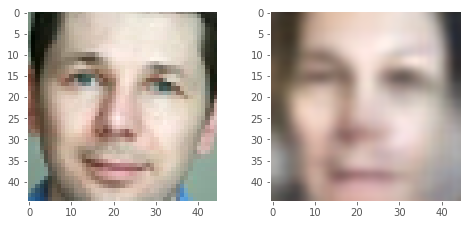

In [125]:
X_andrey_reco = cae.predict(X_andrey.reshape(-1, 45, 45, 3)).reshape(45, 45, 3)

fig = plt.figure(figsize=(8, 3.5))

ax = fig.add_subplot(1, 2, 1)
ax.grid('off')
im = ax.imshow(X_andrey)
if i == 0:
    ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
ax.grid('off')
im = ax.imshow(X_andrey_reco, interpolation='bicubic')
if i == 0:
    ax.set_title('Reconstructed')
    
plt.show()

## Fully Convolutional Denoising AutoEncoder

The idea behind denoising AutoEncoder is define behaviour of the AutoEncoder on points close to these from dataset:
    $$\left\| \mathrm{decode}(\mathrm{encode}(X + \varepsilon))) -X \right\|^2_2 \to \min$$
    
where:
- $\varepsilon \sim \mathcal{N}(0, \sigma^2_\varepsilon)$    

In [77]:
from keras.models import Model
from keras.layers import Input, Reshape, GaussianNoise, Dropout
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal
from keras.activations import relu
from keras.losses import MAE, MSE

In [118]:
def make_denoising_conv_autoencoder(dropout_p = None, noise_stddev=0.1):
    inputs = Input(shape=(45, 45, 3))
    
    leaky_relu = lambda x: relu(x, alpha=2.5e-2)
    
    noise = GaussianNoise(stddev=noise_stddev)(inputs)
    
    net = noise
    
    net = Conv2D(filters=64, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net
    
    net = Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2D(filters=256, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2D(filters=512, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = Conv2D(filters=2048, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    
    net = Dropout(0.25)(net)
    
    net = Conv2DTranspose(filters=512, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    net = Conv2DTranspose(filters = 256, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2DTranspose(filters = 128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2DTranspose(filters = 64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)

    net = Conv2DTranspose(filters = 3, kernel_size=(2, 2), activation='linear', padding='valid')(net)
    
    return Model(inputs=inputs, outputs=net)

In [119]:
dfcae = make_denoising_conv_autoencoder(dropout_p=0.1)

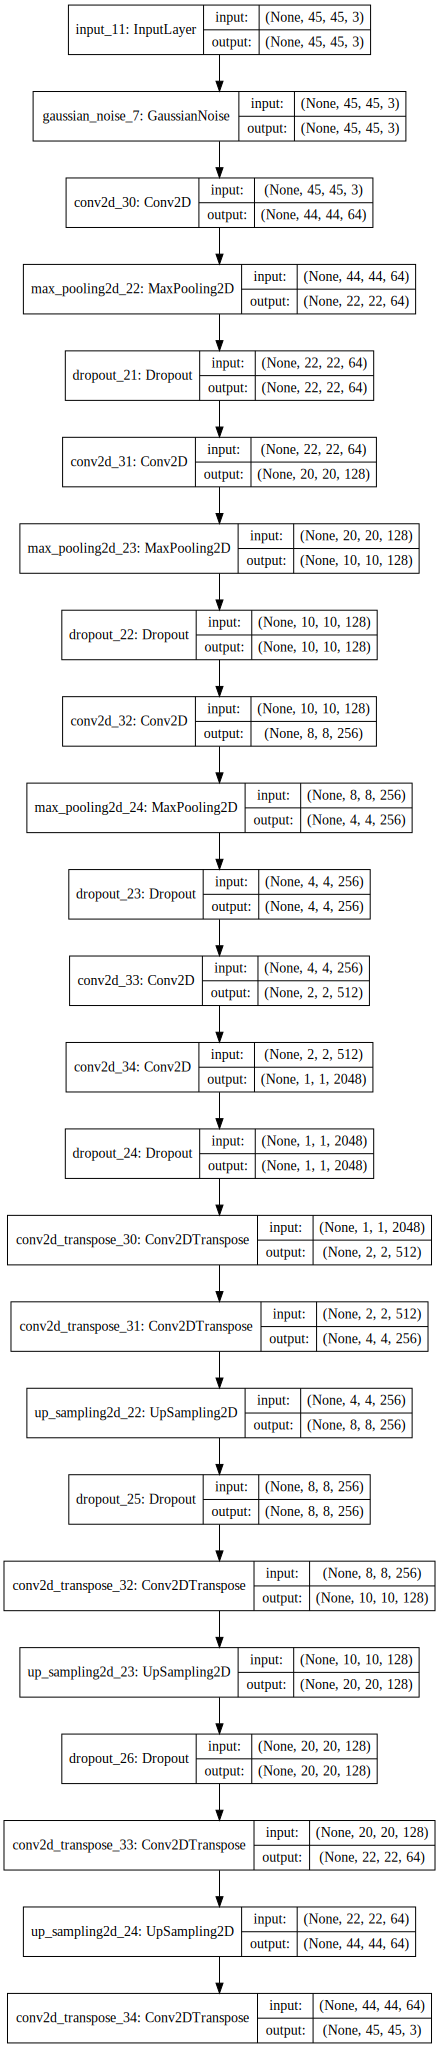

In [120]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(dfcae, show_shapes=True).create(prog='dot', format='svg'))

In [121]:
dfcae.compile(optimizer='adamax', loss='MAE')

In [122]:
dfcae.fit(X_train, X_train, epochs=64)

Epoch 1/64
11828/11828 [==============================] - 22s - loss: 0.1178    
Epoch 2/64
11828/11828 [==============================] - 21s - loss: 0.0768    
Epoch 3/64
11828/11828 [==============================] - 21s - loss: 0.0706    
Epoch 4/64
11828/11828 [==============================] - 21s - loss: 0.0663    
Epoch 5/64
11828/11828 [==============================] - 21s - loss: 0.0634    
Epoch 6/64
11828/11828 [==============================] - 21s - loss: 0.0611    
Epoch 7/64
11828/11828 [==============================] - 21s - loss: 0.0594    
Epoch 8/64
11828/11828 [==============================] - 21s - loss: 0.0578    
Epoch 9/64
11828/11828 [==============================] - 21s - loss: 0.0567    
Epoch 10/64
11828/11828 [==============================] - 21s - loss: 0.0550    
Epoch 11/64
11828/11828 [==============================] - 21s - loss: 0.0539    
Epoch 12/64
11828/11828 [==============================] - 21s - loss: 0.0528    
Epoch 13/64
11828/11828 [

KeyboardInterrupt: 

In [126]:
X_reco = dfcae.predict(X_test)

In [127]:
print(np.mean((X_reco - X_test) ** 2))

0.00667831


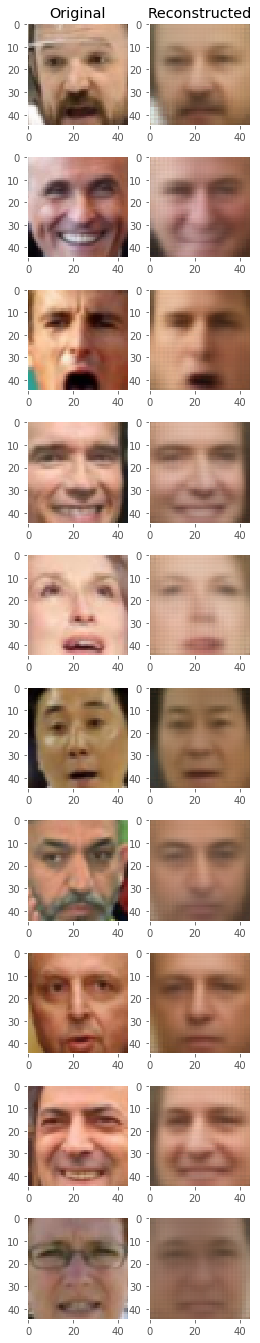

In [128]:
cols = 2
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
plt.show()

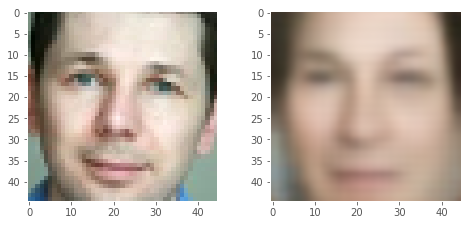

In [129]:
X_andrey_reco = dfcae.predict(X_andrey.reshape(-1, 45, 45, 3)).reshape(45, 45, 3)

fig = plt.figure(figsize=(8, 3.5))

ax = fig.add_subplot(1, 2, 1)
ax.grid('off')
im = ax.imshow(X_andrey)
if i == 0:
    ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
ax.grid('off')
im = ax.imshow(X_andrey_reco, interpolation='bicubic')
if i == 0:
    ax.set_title('Reconstructed')
    
plt.show()

## Bonus: cheap generative model

A simple generative model (almost) is implemented below.

See Bengio, Yoshua, et al. "Deep generative stochastic networks trainable by backprop." International Conference on Machine Learning. 2014. for a more advanced method.

In [130]:
from mnist import load_dataset

In [131]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [132]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [138]:
def make_mnist_autoencoder(dropout_p = None, noise_stddev=0.1):
    inputs = Input(shape=(28, 28, 1))
    
    leaky_relu = lambda x: relu(x, alpha=2.5e-2)
    
    noise = GaussianNoise(stddev=noise_stddev)(inputs)
    
    net = noise
    
    net = Conv2D(filters=32, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = Conv2D(filters=64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net
    
    net = Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2D(filters=256, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)

    net = Conv2DTranspose(filters = 128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2DTranspose(filters = 64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)

    net = Conv2DTranspose(filters = 32, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    net = Conv2DTranspose(filters = 1, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    
    return Model(inputs=inputs, outputs=net)

In [139]:
mnist_ae = make_mnist_autoencoder(dropout_p=0.5)

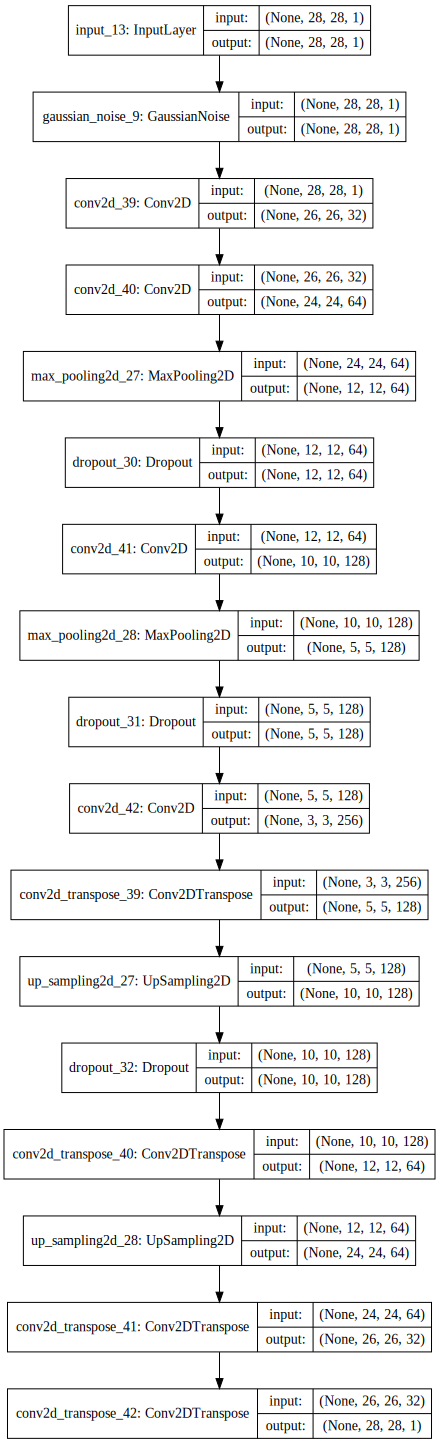

In [140]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(mnist_ae, show_shapes=True).create(prog='dot', format='svg'))

In [141]:
mnist_ae.compile(optimizer='adamax', loss=MSE)

In [143]:
mnist_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=16)

Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 37s - loss: 0.0140 - val_loss: 0.0076
Epoch 2/16
50000/50000 [==============================] - 37s - loss: 0.0097 - val_loss: 0.0057s: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s -
Epoch 3/16
50000/50000 [==============================] - 37s - loss: 0.0081 - val_loss: 0.0051
Epoch 4/16
50000/50000 [==============================] - 37s - loss: 0.0072 - val_loss: 0.0044s: 0. - ETA: 1s - loss:  - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0. - ETA:
Epoch 5/16
50000/50000 [==============================] - 37s - loss: 0.0067 - val_loss: 0.0041s: 0.0 - ETA: 0s - loss: 0.00 - ETA: 0s - 
Epoch 6/16
50000/50000 [==============================] - 37s - loss: 0.0063 - val_loss: 0.0038
Epoch 7/16
50000/50000 [==============================] - 37s - loss: 0.0061 - val_loss: 0.0038A
Epoch 8/16
50000/50000 [==============================] - 37s - loss: 0.0059 - val_loss: 0.0036
Epoch 9/16
50000/50

In [144]:
X_reco = mnist_ae.predict(X_val)

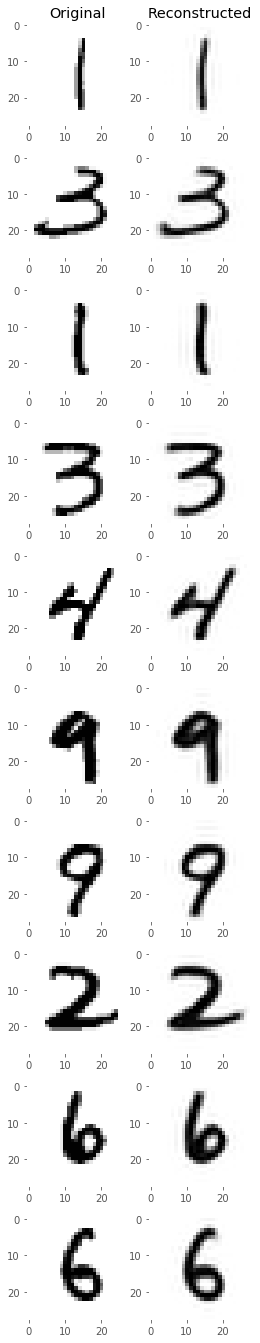

In [145]:
cols = 2
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_val.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_val[k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
    if i == 0:
        ax.set_title('Reconstructed')
    
plt.show()

In [146]:
def mcmc(X, steps = 16, return_each=4, stddev=0.1):
    Xs = [X]
    for i in range(steps // return_each):
        for j in range(return_each):
            X = mnist_ae.predict(X + np.random.normal(size=X.shape).astype('float32') * stddev)
        
        Xs.append(X)
    
    return Xs

In [147]:
Xs = mcmc(X_test[:100], steps=256, return_each=32, stddev=0.15)

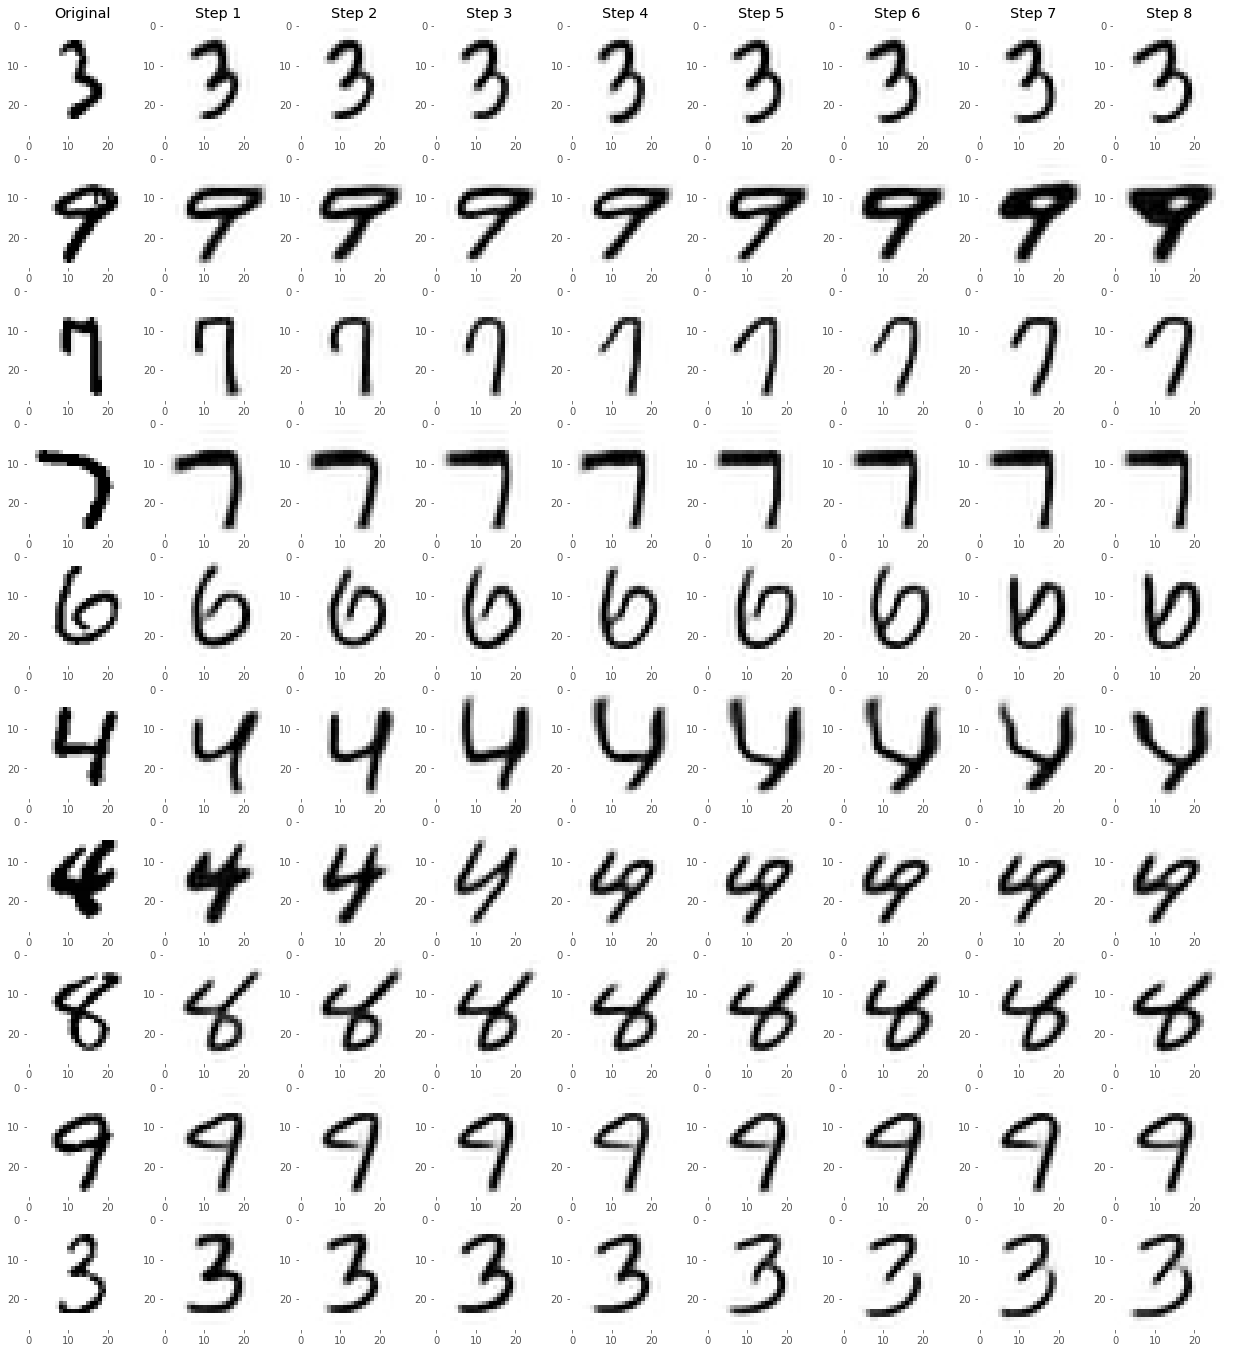

In [148]:
cols = len(Xs)
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, Xs[0].shape[0])
    
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i * cols + j + 1)
        ax.grid('off')
        im = ax.imshow(Xs[j][k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
        if i == 0:
            if j == 0:
                ax.set_title('Original')
            else:
                ax.set_title('Step %d' % j)
    
plt.show()